# Problem formulation:

In [ ]:
# Importing useful libraries

import numpy as np
import matplotlib.pyplot as plt
import time


In [ ]:

# Initial conditions
Atmosphere_Initial = 750
CarbonateRock_Initial = 100000000
DeepOcean_Initial = 38000
FossilFuel_Initial = 7500
Plant_Initial = 560
Soil_Initial = 1500
SurfaceOcean_Initial = 890
VegLandArea_percent_Initial = 100

x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial])

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)

def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)

def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)

def WaterTemp(GlobalTemp):
    return 273+GlobalTemp

def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96

def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol

def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))

def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))

def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)

def CO3(HCO3):
    return (Alk-HCO3)/2

def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)

# Fossil fuels
FossFuelData = np.array([[1850.0, 0.00], [1875.0, 0.30], [1900.0, 0.60], [1925.0, 1.35], [1950.0, 2.85], [1975.0, 4.95], [2000.0, 7.20], [2025.0, 10.05], [2050.0, 14.85], [2075.0, 20.70], [2100.0, 30.00]])

def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])

# Write an explanation of what this fct does
def derivative(x, t):
    Atmosphere = x[0]
    CarbonateRock = x[1]
    DeepOcean = x[2]
    FossilFuelCarbon = x[3]
    Plants = x[4]
    Soils = x[5]
    SurfaceOcean = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial))+(Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp + SoilResp + Volcanoes + FossilFuelsCombustion_
                          - Photosynthesis - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt= Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
        ])

    return derivative


Rewriting the equations mathematically yields a system consisting of eight equations as follows:

1. $$\frac{dA}{dt} = R_P + R_S + V + F_{\text{Vol}} - \text{Photosynthesis} - \text{AtmOcExchange}$$
2. $$\frac{dC}{dt} = S - F_{\text{Vol}}$$
3. $$\frac{dD}{dt} = \text{Downwelling} - S - \text{Upwelling}$$
4. $$\frac{dF}{dt} = -F_{\text{Vol}}$$
5. $$\frac{dP}{dt} = \text{Photosynthesis} - \text{R_P} - \text{Litterfall}$$
6. $$\frac{dS}{dt} = \text{Litterfall} - \text{R_S}$$
7. $$\frac{dO}{dt} = \text{Upwelling} + \text{AtmOcExchange} - \text{Downwelling}$$
8. $$\frac{dV}{dt} = -\text{Development}$$

Where  \( $t$ \) is the time variable, and the following are the state variables:

- \( $A$ \): Atmospheric CO2 concentration.
- \( $C$ \): Amount of carbon stored in carbonate rocks.
- \( $D$ \): Amount of dissolved carbon in the deep ocean.
- \( $F$ \): Amount of carbon emitted from fossil fuel combustion.
- \( $P$ \): Biomass of plants.
- \( $S$ \): Amount of carbon stored in soils.
- \( $O$ \): Amount of dissolved carbon in the surface ocean.
- \( $V$ \): Percentage of land covered by vegetation.



**1. Continuity**

Most of the helper functions (`AtmCO2`, `GlobalTemp`, `CO2Effect`, `WaterTemp`, `TempEffect`, `SurfCConc`, `Kcarb`, `KCO2`, `HCO3`, `CO3`, `pCO2Oc`) are composed of arithmetic operations and basic mathematical functions that are known to be continuous on their domain of definition. Thus, these functions are continuous on their domains.

**2. Differentiability**

The functions are primarily linear or involve terms that are smooth (like the square root in the `HCO3` calculation, which is differentiable for positive arguments), so they are differentiable within their domains where their mathematical operations are defined. However, the denominator must not be zero where division occurs, as differentiability will not hold at such points.

**3. Lipschitz Continuity**

To determine Lipschitz continuity, we must examine the derivatives of the functions, as a bounded derivative on a domain is one way to establish Lipschitz continuity. Given the general form of the functions in the carbon cycle model:
  - Functions like `GlobalTemp` and `CO2Effect`, which are linear or have simple ratios, likely satisfy Lipschitz continuity over their relevant domains because their derivatives are bounded.
  - For functions involving more complex operations (e.g., `HCO3`), establishing Lipschitz continuity would depend on analyzing the behavior of their derivatives across the domain to ensure they remain bounded.


In the following section, we have coded numerical methods for solving system of ODEs. For each method, we plot the evolution of variables in the system. In each plot, we pay particular attention to the athmospheric CO2 concentration, which is an indivator for increasing temperatures in the athmosphere. Afterwards, we compute the errors by comparing the result of each integration method with Runge-kutta 4 method.

# Left rectangle Method (Forward Euler)

The forward Euler method is of order one and isn't necessarily stable if the stepsize is too big.

In [ ]:
def left_rectangle_Euler(derivative, x0, t):
    num_steps = len(t)
    num_states = len(x0)
    result = np.zeros((num_steps, num_states)) #matrix to store the evolution of each variable
    result[0] = x0  # Initial conditions
    dt = t[1] - t[0]  #we move forward with constant step size, no need to update

    for i in range(num_steps - 1):
        t_i = t[i]
        x_i = result[i]
        k1 = derivative(x_i, t_i)
        result[i + 1] = x_i + k1 * dt  # estimate new state X_(i+1) by simply going across the derivative at X_i.

    return result

Execution time of Left rectangle method: 0.09005188941955566 seconds


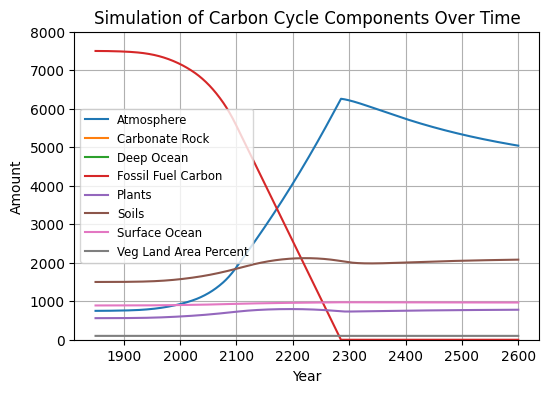

In [ ]:
# Integrate the system of differential equations
t = np.linspace(1850, 2600, 5000)  # Define the time interval
x0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Initial conditions
start_time = time.time()  # Start time
result = left_rectangle_Euler(derivative, x0, t)
end_time = time.time()  # End time
execution_time = end_time - start_time  # Calculate execution time
print("Execution time of Left rectangle method:", execution_time, "seconds")

plt.figure(figsize=(6, 4))  # Create a figure with a custom size

# Plot each variable
plt.plot(t, result[:, 0], label='Atmosphere')
plt.plot(t, result[:, 1], label='Carbonate Rock')
plt.plot(t, result[:, 2], label='Deep Ocean')
plt.plot(t, result[:, 3], label='Fossil Fuel Carbon')
plt.plot(t, result[:, 4], label='Plants')
plt.plot(t, result[:, 5], label='Soils')
plt.plot(t, result[:, 6], label='Surface Ocean')
plt.plot(t, result[:, 7], label='Veg Land Area Percent')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Simulation of Carbon Cycle Components Over Time')

# Add a legend to identify each line
plt.legend(fontsize='small')  # Adjusts the font size of the legend
plt.ylim(0, 8000)

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()

# Trapezoid method - Heun's method

This method is a Runge-Kutta method of order 2, thus we can say that it is convergent since all Runge-Kutta methods are by property.

In [ ]:
def trapezoid_method(derivative, x0, t):
    num_steps = len(t)
    num_states = len(x0)
    result = np.zeros((num_steps, num_states)) # matrix to store the evolution of each variable
    result[0] = x0  # Initial conditions
    dt = t[1] - t[0]  #we move forward with constant step size, no need to update

    for i in range(num_steps - 1):
        t_i = t[i]
        x_i = result[i]
        k1 = derivative(x_i, t_i)
        x_temp = x_i + k1 * dt
        k2 = derivative(x_temp, t[i+1])  # t[i+1] is by definition t[i] + dt
        k = 0.5 * (k1 + k2)
        result[i + 1] = x_i + k * dt  # estimate new state X_(i+1) by simply going across the derivative at X_i.

    return result

Execution time of Trapezoid Method: 0.2605757713317871 seconds


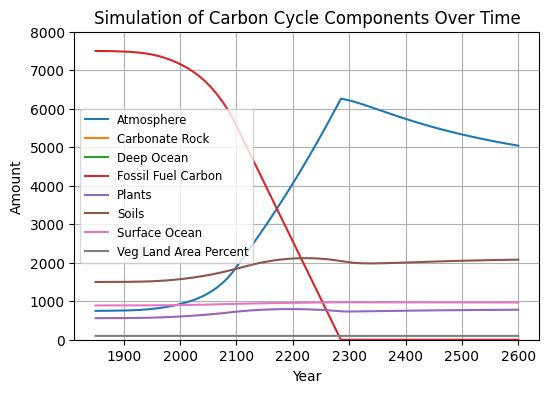

In [ ]:
# Integrate the system of differential equations
t = np.linspace(1850, 2600, 5000)  # Define the time interval
x0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Initial conditions
start_time = time.time()  # Start time
result = trapezoid_method(derivative, x0, t)
end_time = time.time()  # End time
execution_time = end_time - start_time  # Calculate execution time
print("Execution time of Trapezoid Method:", execution_time, "seconds")

plt.figure(figsize=(6, 4))  # Create a figure with a custom size

# Plot each variable
plt.plot(t, result[:, 0], label='Atmosphere')
plt.plot(t, result[:, 1], label='Carbonate Rock')
plt.plot(t, result[:, 2], label='Deep Ocean')
plt.plot(t, result[:, 3], label='Fossil Fuel Carbon')
plt.plot(t, result[:, 4], label='Plants')
plt.plot(t, result[:, 5], label='Soils')
plt.plot(t, result[:, 6], label='Surface Ocean')
plt.plot(t, result[:, 7], label='Veg Land Area Percent')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Simulation of Carbon Cycle Components Over Time')

# Add a legend to identify each line
plt.legend(fontsize='small')  # Adjusts the font size of the legend
plt.ylim(0, 8000)


# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()

# Midtpoint method (RK2)

The RK2 method is convergent and of order 2.

In [ ]:
def midpoint_method(derivative, x0, t):
    num_steps = len(t)
    num_states = len(x0)
    result = np.zeros((num_steps, num_states)) #matrix to store the evolution of each variable
    result[0] = x0  # Initial conditions
    dt = t[1] - t[0]  #we move forward with constant step size, no need to update

    for i in range(num_steps - 1):
        t_i = t[i]
        x_i = result[i]
        k1 = derivative(x_i, t_i)
        x_temp = x_i + k1 * dt * 0.5 # Going forward by half a step
        k2 = derivative(x_temp, 0.5 * (t[i] + t[i+1]))  # derivative at a half step away from x_i
        result[i + 1] = x_i + k2 * dt  # estimate new state X_(i+1) by simply going across the derivative at X_i.

    return result

Execution time of RK2 Midpoint Method: 0.1668386459350586 seconds


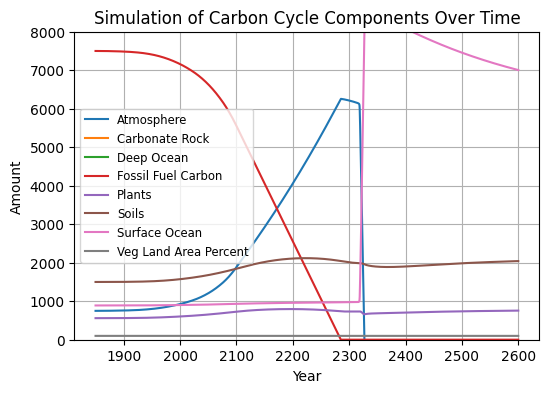

In [ ]:
# Integrate the system of differential equations
t = np.linspace(1850, 2600, 5000)  # Define the time interval
x0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Initial conditions
start_time = time.time()  # Start time
result = midpoint_method(derivative, x0, t)
end_time = time.time()  # End time
execution_time = end_time - start_time  # Calculate execution time
print("Execution time of RK2 Midpoint Method:", execution_time, "seconds")


plt.figure(figsize=(6, 4))  # Create a figure with a custom size

# Plot each variable
plt.plot(t, result[:, 0], label='Atmosphere')
plt.plot(t, result[:, 1], label='Carbonate Rock')
plt.plot(t, result[:, 2], label='Deep Ocean')
plt.plot(t, result[:, 3], label='Fossil Fuel Carbon')
plt.plot(t, result[:, 4], label='Plants')
plt.plot(t, result[:, 5], label='Soils')
plt.plot(t, result[:, 6], label='Surface Ocean')
plt.plot(t, result[:, 7], label='Veg Land Area Percent')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Simulation of Carbon Cycle Components Over Time')

# Add a legend to identify each line
plt.legend(fontsize='small')  # Adjusts the font size of the legend
plt.ylim(0, 8000)

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()

# Runge-Kutta (RK4)

The RK4 method is convergent and of order 4.

In [ ]:
#Compare what the results are using this method to the ones provided by the online tool
#Demonstrate the convergence of this numerical method
def rk4(derivative, x0, t):
    num_steps = len(t)
    num_states = len(x0)
    result = np.zeros((num_steps, num_states)) #matrix to store the evolution of each variable
    result[0] = x0  # Initial conditions
    dt = t[1] - t[0]  #we move forward with constant step size, no need to update

    for i in range(num_steps - 1):
        t_i = t[i]
        x_i = result[i]
        #step 1
        k1 = derivative(x_i, t_i)
        x_temp_1 = x_i + k1 * dt * 0.5 # Going forward by half a step
        k2 = derivative(x_temp_1, 0.5 * (t[i] + t[i+1]))  # derivative at a half step away from x_i
        #step 2
        x_temp_2 = x_i + k2 * dt * 0.5 # Going forward by half a step
        k3 = derivative(x_temp_2, 0.5 * (t[i] + t[i+1]))
        #step 3
        x_temp_3 = x_i + k3 * dt
        k4 = derivative(x_temp_3, t[i+1])
        #final gradient
        k = (1/6)*k1 + (2/6)*k2 + (2/6)*k3 + (1/6)*k4

        result[i + 1] = x_i + k * dt  # estimate new state X_(i+1) by simply going across the derivative at X_i.

    return result

Execution time of RK4 Midpoint Method: 0.5273687839508057 seconds


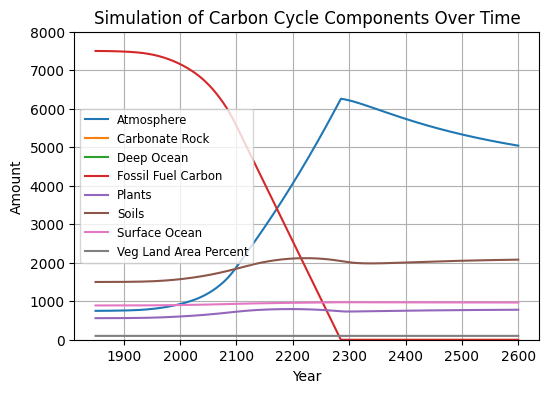

In [ ]:
# Integrate the system of differential equations
t = np.linspace(1850, 2600, 5000)  # Define the time interval
x0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Initial conditions
start_time = time.time()  # Start time
result = rk4(derivative, x0, t)
end_time = time.time()  # End time
execution_time = end_time - start_time  # Calculate execution time
print("Execution time of RK4 Midpoint Method:", execution_time, "seconds")

plt.figure(figsize=(6, 4))  # Create a figure with a custom size

# Plot each variable
plt.plot(t, result[:, 0], label='Atmosphere')
plt.plot(t, result[:, 1], label='Carbonate Rock')
plt.plot(t, result[:, 2], label='Deep Ocean')
plt.plot(t, result[:, 3], label='Fossil Fuel Carbon')
plt.plot(t, result[:, 4], label='Plants')
plt.plot(t, result[:, 5], label='Soils')
plt.plot(t, result[:, 6], label='Surface Ocean')
plt.plot(t, result[:, 7], label='Veg Land Area Percent')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Simulation of Carbon Cycle Components Over Time')

# Add a legend to identify each line
plt.legend(fontsize='small')  # Adjusts the font size of the legend
plt.ylim(0, 8000)

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()

# Two-step Adam-Bashforth Method:

The two-step Adams-Bashforth method is convergent and of order 2.

In [ ]:
def two_step_adams_bashforth(derivative, x0, t):
    num_steps = len(t)
    num_states = len(x0)
    result = np.zeros((num_steps, num_states))  # Matrix to store the evolution of each variable
    result[0] = x0  # Initial conditions

    # Initialize the first step with a simple method, e.g. here it's Euler method:
    dt = t[1] - t[0]
    result[1] = result[0] + dt * derivative(result[0], t[0])

    # calculate the next steps based on the 2 previous steps:
    for n in range(1, num_steps - 1):
        f_n_plus = derivative(result[n], t[n])
        f_n = derivative(result[n-1], t[n-1])
        result[n+1] = result[n] + dt * ((3/2) * f_n_plus - (1/2) * f_n)

    return result

Execution time of Adams-Bashforth method: 0.17961502075195312 seconds


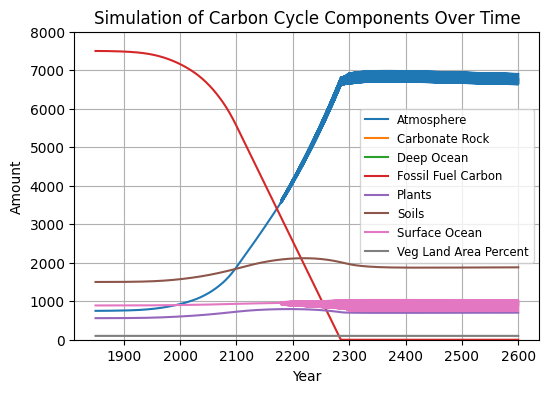

In [ ]:
# Integrate the system of differential equations
t = np.linspace(1850, 2600, 5000)  # Define the time interval
x0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Initial conditions
start_time = time.time()  # Start time
result = two_step_adams_bashforth(derivative, x0, t)
end_time = time.time()  # End time
execution_time = end_time - start_time  # Calculate execution time
print("Execution time of Adams-Bashforth method:", execution_time, "seconds")

plt.figure(figsize=(6, 4))  # Create a figure with a custom size

# Plot each variable
plt.plot(t, result[:, 0], label='Atmosphere')
plt.plot(t, result[:, 1], label='Carbonate Rock')
plt.plot(t, result[:, 2], label='Deep Ocean')
plt.plot(t, result[:, 3], label='Fossil Fuel Carbon')
plt.plot(t, result[:, 4], label='Plants')
plt.plot(t, result[:, 5], label='Soils')
plt.plot(t, result[:, 6], label='Surface Ocean')
plt.plot(t, result[:, 7], label='Veg Land Area Percent')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Simulation of Carbon Cycle Components Over Time')

# Add a legend to identify each line
plt.legend(fontsize='small')  # Adjusts the font size of the legend
plt.ylim(0, 8000)

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()

For the two-step Adams-Bashforth algorithm, the results notably improve when we increase the number of time steps, as illustrated by the plot below:

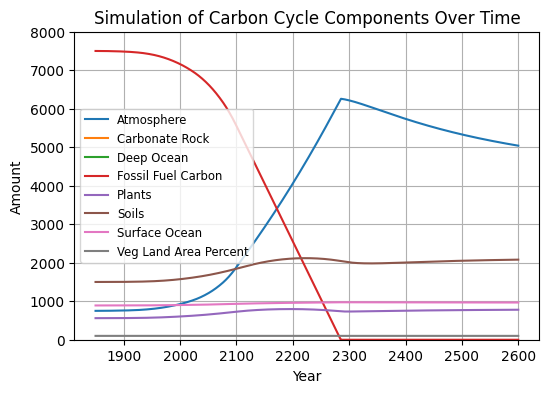

In [ ]:
# Integrate the system of differential equations
t = np.linspace(1850, 2600, 10000)  # Define the time interval
x0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Initial conditions

result = two_step_adams_bashforth(derivative, x0, t)

plt.figure(figsize=(6, 4))  # Create a figure with a custom size

# Plot each variable
plt.plot(t, result[:, 0], label='Atmosphere')
plt.plot(t, result[:, 1], label='Carbonate Rock')
plt.plot(t, result[:, 2], label='Deep Ocean')
plt.plot(t, result[:, 3], label='Fossil Fuel Carbon')
plt.plot(t, result[:, 4], label='Plants')
plt.plot(t, result[:, 5], label='Soils')
plt.plot(t, result[:, 6], label='Surface Ocean')
plt.plot(t, result[:, 7], label='Veg Land Area Percent')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Simulation of Carbon Cycle Components Over Time')

# Add a legend to identify each line
plt.legend(fontsize='small')  # Adjusts the font size of the legend
plt.ylim(0, 8000)

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()

Analyzing all the methods, in terms of performance, it appears that the Adams-Bashforth method is the fastest, followed by the Left Rectangle one, Trapezoid, Midpoint RK2, and RK4.

# Study of errors

We will use RK4 method to get the best approximation of our ODE solution. \\

**Order of Accuracy**

The RK4 method's fourth-order accuracy means that for a given differential equation, the error in the numerical solution decreases at a rate proportional to dt^4, where dt is the step size used in the integration process. In practical terms, if we were to halve the step size, we would expect the error to reduce by a factor of 16. However, this property assumes that the function being integrated behaves nicely over the integration interval – specifically, it requires the function and its derivatives up to the fourth order to be continuous and bounded.

For our system, which models the carbon cycle through multiple interconnected components (atmosphere, carbonate rock, deep ocean, etc.), the order of accuracy suggests that as we refine the time steps (making dt smaller), we should see a significant improvement in the precision of our results, assuming the system's behavior does not introduce discontinuities or extreme sensitivities in the response to input changes (which could be the case with complex feedback loops and non-linearities inherent in climate models).

**Stability**

The stability of the RK4 method refers to its ability to produce reasonable approximations over a range of step sizes without the solutions becoming unbounded or exhibiting non-physical oscillations. Stability is particularly crucial in long-term simulations or when dealing with stiff equations, where certain terms might lead to rapid changes over short time scales.

Our problem includes various processes with potentially differing time scales (e.g., atmospheric CO2 exchange with the ocean, fossil fuel combustion, photosynthesis, and changes in land use). The RK4 method is generally stable for non-stiff problems, but if parts of our model (like the feedback mechanisms between temperature, CO2 levels, and ecosystem responses) behave stiffly over certain ranges, we might encounter stability issues. In such cases, while RK4 offers a good balance between accuracy and computational efficiency for many problems, we may need to adjust the step size.


To ensure the RK4 method's stability and accuracy, we will use a small stepsize to get the best approximation and in the following, treat such solution as the best approximation. The result in the code of this method is calculated below and is saved in variable: "result_best"

# Error Methods

In [ ]:
t = np.linspace(1850, 2600, 5000)  # Define the time interval
x0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Initial conditions

In [ ]:
# All integration methods
result_left = left_rectangle_Euler(derivative, x0, t)
result_trapezoid = trapezoid_method(derivative, x0, t)
result_midpoint = midpoint_method(derivative, x0, t)
result_rk4 = rk4(derivative, x0, t)

In [ ]:
# Study of error of Rk4 as the stepsize decreases
stepsize = np.arange(5000, 50001, 2000)

In [ ]:
# Initialize an empty list to store the results of the RK4 method for different step sizes
result_rk4_all = []

# Loop through each step size specified in the 'stepsize' array or list
for i in stepsize:
  # Generate an array of time points from 1850 to 2600, with the number of points equal to the current step size 'i'
  t = np.linspace(1850, 2600, i)

  # Call the 'rk4' function to solve the differential equation using the 4th-order Runge-Kutta method
  # The 'rk4' function takes the derivative function, initial conditions 'x0', and the generated time points 't'
  result_rk4 = rk4(derivative, x0, t)

  # Append the result of the RK4 method for the current step size to the 'result_rk4_all' list
  result_rk4_all.append(result_rk4)

In [ ]:
#computing approximations for different values of stepsizes for Left Rectangle Method. Same idea as above.
result_left_all = []
for i in stepsize:
  t = np.linspace(1850, 2600, i)
  result_left = left_rectangle_Euler(derivative, x0, t)
  result_left_all.append(result_left)

In [ ]:
#computing approximations for different values of stepsizes for Trapezium Method. Same idea as above.
result_trapezoid_all = []
for i in stepsize:
  t = np.linspace(1850, 2600, i)
  result_trapezoid = trapezoid_method(derivative, x0, t)
  result_trapezoid_all.append(result_trapezoid)

In [ ]:
#computing approximations for different values of stepsizes for Midpoint method. Same idea as above.
result_midpoint_all = []
for i in stepsize:
  t = np.linspace(1850, 2600, i)
  result_midpoint = midpoint_method(derivative, x0, t)
  result_midpoint_all.append(result_midpoint)

# Error of Left Rectangle Method

In [ ]:
# Initialize an empty list to store the maximum error between RK4 and Left Rectangle results for each step size
error_av_left = []

# Initialize a counter to access the corresponding results from RK4 and Left Rectangle methods by index
counter = 0

# Loop through each step size defined in 'stepsize'
for i in stepsize:
  # Retrieve the result from the Left Rectangle Method for the current step size using the counter for indexing
  result_left = result_left_all[counter]

  # Similarly, retrieve the result from the RK4 method for the current step size
  result_rk4 = result_rk4_all[counter]

  # Calculate the abs error between the two methods at each point
  error_1 = np.abs(result_rk4 - result_left)

  # Calculate the maximum error for the current step size by finding the max value of 'error_1'
  av_error_1 = np.max(error_1)

  # Uncommented line is for appending each error to a list, but it's not used in the current version of the code
  # error.append(error_1)

  # Append the maximum error for the current step size to the 'error_av_left' list
  error_av_left.append(av_error_1)

  # Increment the counter to move to the next set of results for the subsequent step size
  counter += 1

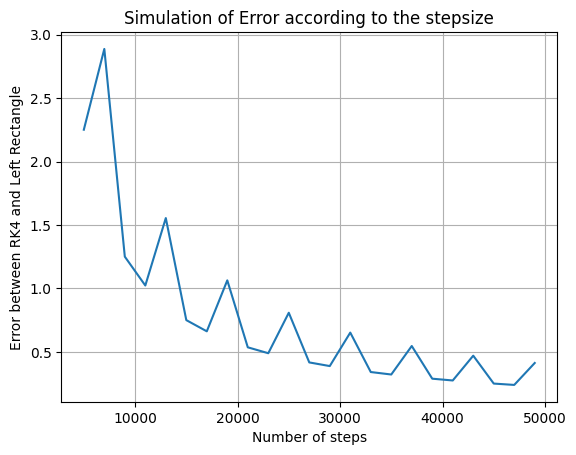

In [ ]:
error_av_left
plt.plot(stepsize, error_av_left)
# Adding labels and title
plt.xlabel('Number of steps')
plt.ylabel('Error between RK4 and Left Rectangle')
plt.title('Simulation of Error according to the stepsize')

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()

# Error of Trapezoid

In [ ]:
#same idea as above
error_av_trapezoid = []
counter = 0
for i in stepsize:
  result_trapezoid = result_trapezoid_all[counter]
  result_rk4 = result_rk4_all[counter]
  error_1 = np.abs(result_rk4 - result_trapezoid)
  av_error_1 = np.max(error_1)
  error_av_trapezoid.append(av_error_1)
  counter += 1

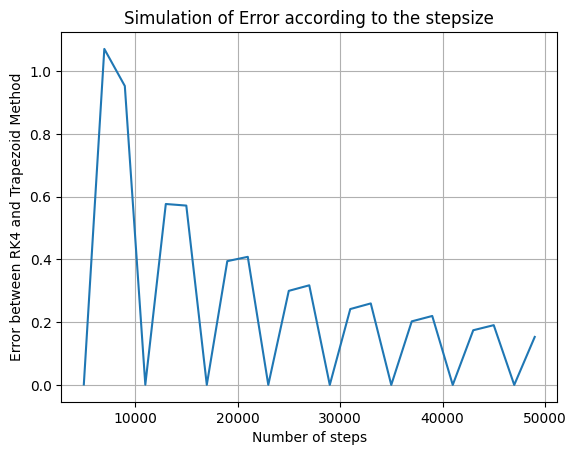

In [ ]:
plt.plot(stepsize, error_av_trapezoid)
# Adding labels and title
plt.xlabel('Number of steps')
plt.ylabel('Error between RK4 and Trapezoid Method')
plt.title('Simulation of Error according to the stepsize')

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()


# Integrate the system of differential equations
t_small = np.linspace(1850, 2600, 10000)  # Define the time interval (Hence the step-size)
x0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Initial conditions
result_best = rk4(derivative, x0, t_small)

Code cell <Qle3U6cdIwqI>
# %% [code]
t_large = t_small[::1000]
#error = np.abs(result_best[::100] - result_left_rectangle)
#max_error = np.max(error)

Code cell <Rk86I38AI2JL>
# %% [code]
# Studying the error evolution with increasing number of points in t, hence decreasing the step size
n_factor = np.arange(4000, 7000, 100)
#n_factor = np.flip(np.sort(n_factor)) # parameter that defines what proportion of 500000 points we take for our estimation. Smaller means more points and larger means less points.
            # We expect that for smaller number of n_factor, the error decreases, and the ODE solution approximation approaches the best approximation.

Code cell <dWR4an2sI7yz>
# %% [code]
def error_1(t_small, n, result_best): #computes max error of a method given n
  t_large = t_small[::n]
  result_left_rectangle = left_rectangle_Euler(derivative, x0, t_large)
  error = np.abs(result_best[::n] - result_left_rectangle)
  max_error = np.max(error)
  return max_error

Code cell <AiyL-bRENJcm>
# %% [code]
def error_2(t_small, n, result_best): #computes mean error of a method given n
  t_large = t_small[::n]
  result_left_rectangle = trapezoid_method(derivative, x0, t_large)
  error = np.abs(result_best[::n] - result_left_rectangle)
  av_error = np.mean(error)
  return av_error

Code cell <5DUAvA5nKoQD>
# %% [code]
out = error_1(t_small, 9000, result_best)

Code cell <cNNZAwWVK55L>
# %% [code]
out
Execution output from Apr 3, 2024 9:54 PM
0KB
	text/plain
		7500.930476699712

Code cell <OVC_5m3UJB0t>
# %% [code]
error = []
for i in n_factor:
  out = error_2(t_small, i, result_best)
  error.append(out)
error
Execution output from Apr 3, 2024 9:54 PM
1KB
	text/plain
		[109723166.43765801,
		 116956502.28124563,
		 124555722.01326673,
		 132528083.10381228,
		 140881096.43378812,
		 149622480.7538388,
		 158760126.49721596,
		 168302066.95040044,
		 178256457.04901308,
		 188631554.4894745,
		 222.5253583321861,
		 227.10768041751274,
		 231.3447978472838,
		 235.22839993311788,
		 238.74924133328102,
		 241.897114007232,
		 244.66081550979115,
		 247.0281113576981,
		 248.98568971716418,
		 251.21191491220208,
		 254.31796327271303,
		 257.98439015191644,
		 262.0420723805659,
		 266.3771569559384,
		 270.90404152957717,
		 275.5560116358653,
		 280.2806267485702,
		 289.7021129219836,
		 308.521319544174,
		 327.31471633002724]

Code cell <J3pT8EQfMgbJ>
# %% [code]
len(error)
Execution output from Apr 3, 2024 9:54 PM
0KB
	text/plain
		30

Code cell <7m9hlpTxLVoZ>
# %% [code]
plt.plot(n_factor[:41], error[:41])
# Adding labels and title
plt.xlabel('Number of steps')
plt.ylabel('Error between RK4 and Midpoint Method')
plt.title('Simulation of Error according to the stepsize')

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()
Execution output from Apr 3, 2024 9:54 PM
41KB
	text/plain
		<Figure size 640x480 with 1 Axes>

Code cell <Z1phD1xhsB0r>
# %% [code]
error = []
for i in n_factor:
  out = error_1(t_small, i, result_best)
  error.append(out)
error
Execution output from Apr 3, 2024 10:41 PM
1KB
	text/plain
		[4233.2652907184865,
		 4517.4693356053895,
		 4798.824109871193,
		 5077.4406623090845,
		 5353.4400112854,
		 5626.94621973012,
		 5898.08227779952,
		 6166.967741237402,
		 6433.717457070692,
		 6698.440954422124,
		 5697.375121166881,
		 5922.397623416767,
		 6147.420125666652,
		 6372.442627916537,
		 6597.465130166423,
		 6822.487632416308,
		 7047.510134666193,
		 7272.532636916078,
		 7497.555139165964,
		 7500.930476699712,
		 7500.930476699712,
		 7500.930476699712,
		 7500.930476699712,
		 7500.930476699712,
		 7500.930476699712,
		 7500.930476699712,
		 7500.930476699712,
		 7500.930476699712,
		 7500.930476699712,
		 7500.930476699712]

Code cell <8qiCbZK6sjaL>
# %% [code]
plt.plot(n_factor, error)
# Adding labels and title
plt.xlabel('Number of steps')
plt.ylabel('Error between RK4 and Midpoint Method')
plt.title('Simulation of Error according to the stepsize')

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()
Execution output from Apr 3, 2024 10:42 PM
46KB
	text/plain
		<Figure size 640x480 with 1 Axes>




# Stability

In order to numerically observe the stability of our methods, we employ the following strategy. We add random gaussian variation to the initial condition vector of values. We then observe it such perturbation impacts convergence of the algorithms.

For clarity, in the following visualisations, we only plot the atmosphere parameter for each method.

In [ ]:
# Original initial conditions
x0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])

# Normal
normal_noise = np.random.normal(loc=0, scale=10, size=x0.shape)
x0_normal_perturbed = x0 + normal_noise

# Print to verify
print("Original:", x0)
print("Normal Perturbation:", x0_normal_perturbed)

Original: [      750 100000000     38000      7500       560      1500       890
       100]
Normal Perturbation: [7.40433345e+02 1.00000006e+08 3.79815219e+04 7.50271041e+03
 5.61968578e+02 1.49576346e+03 9.02587838e+02 8.51292192e+01]


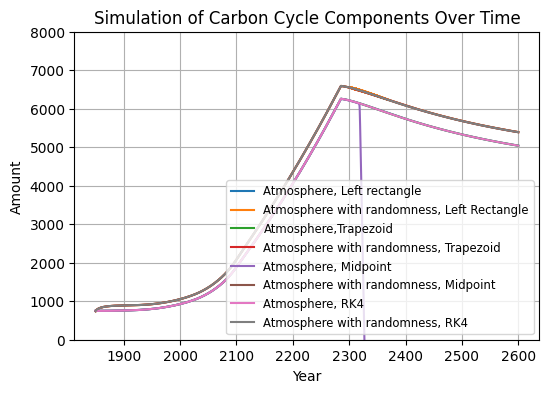

In [ ]:
#Left rectangle with perturbation
# Integrate the system of differential equations
t = np.linspace(1850, 2600, 5000)  # Define the time interval

result_left = left_rectangle_Euler(derivative, x0, t)
result_left_perturbed = left_rectangle_Euler(derivative, x0_normal_perturbed, t)
result_trapezoid = trapezoid_method(derivative, x0, t)
result_trapezoid_perturbed = trapezoid_method(derivative, x0_normal_perturbed, t)
result_midpoint = midpoint_method(derivative, x0, t)
result_midpoint_perturbed = midpoint_method(derivative, x0_normal_perturbed, t)
result_rk4 = rk4(derivative, x0, t)
result_rk4_perturbed = rk4(derivative, x0_normal_perturbed, t)

plt.figure(figsize=(6, 4))  # Create a figure with a custom size

# Plot each variable
plt.plot(t, result_left[:, 0], label='Atmosphere, Left rectangle')
plt.plot(t, result_left_perturbed[:, 0], label='Atmosphere with randomness, Left Rectangle')

plt.plot(t, result_trapezoid[:, 0], label='Atmosphere,Trapezoid')
plt.plot(t, result_trapezoid_perturbed[:, 0], label='Atmosphere with randomness, Trapezoid')

plt.plot(t, result_midpoint[:, 0], label='Atmosphere, Midpoint')
plt.plot(t, result_midpoint_perturbed[:, 0], label='Atmosphere with randomness, Midpoint')

plt.plot(t, result_rk4[:, 0], label='Atmosphere, RK4')
plt.plot(t, result_rk4_perturbed[:, 0], label='Atmosphere with randomness, RK4')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Simulation of Carbon Cycle Components Over Time')

# Add a legend to identify each line
plt.legend(fontsize='small')  # Adjusts the font size of the legend
plt.ylim(0, 8000)

# Add grid for easier reading
plt.grid(True)

# Display the plot
plt.show()

As illustrated in the above graph, all methods stay stable despite initial gaussian perturbations.

In addition, we can see that the problem of convergence for the midpoint method with the initial condition and the stepsize is solved when perturbation is added. This shows that in the original implementation, numerical error was taking place which seems to be avoided with randomness.

Conclusion:

We can therefore conclude that to the best of our knowledge the simulation provided in the problem definition is precise given the physical information and initial conditions given. Unfortunately, we observe the drastic increase in the CO2 concentration until tipping point between 2200 and 2300, matching the feelings of the rabbit.